# Predicción Multi-label con Amazon Planet dataset

En este notebook vamos a realizar una práctica de predicción *multi-label* siguiendo la [*lesson* 3 del curso de Deep Learning de fastai](https://course.fast.ai/videos/?lesson=3/).

Para ello vamos a emplear el dataset [*Planet: understanding Amazon from the space* de Kaggle](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/). Se trata de predecir las etiquetas que mejor describen una imagen de satélite del Amazonas; *cloudy, haze, road, primary, etc.*

Con los siguientes [*magic commands*](https://ipython.readthedocs.io/en/stable/interactive/magics.html/) nos aseguramos de recargar de forma automática cualquier modificación de las librerías o de los gráficos.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# **Cargamos las imágenes**

Desde *fastai* importamos el módulo *vision* para poder trabajar con imágenes.

In [2]:
from fastai.vision import *

No he podido obtener el dataset desde la API de *fastai*, así que debo dar las gracias al colega [JonathanSum](https://forums.fast.ai/t/if-you-problem-with-the-planet-data-here-is-the-link-for-download/62809/) que ha compartido un acceso al dataset desde su cuentade Google Drive.

Si trabajamos desde Google Collab, podemos conectar nuestro entorno de ejecución con nuestra cuenta de Google Drive.

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Como este notebook va a correr en [Gradient](https://gradient.paperspace.com/), subimos el conjunto de archivos del dataset a nuestro *storage*.

En la variable "path" establecemos la ruta de acceso a nuestro dataset.

In [19]:
# Para acceder al dataset en Drive desde Google Colab
# path = '/content/drive/My Drive/planet'
# path

# Para acceder al dataset desde Gradient
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path 

PosixPath('/storage/planet')

Con el signo '!' accedemos a la consola para instalar 'eidl7zip' y poder descomprimir los archivos.

In [16]:
! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/fastai

  added / updated specs:
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         125 KB
    certifi-2019.11.28         |           py36_0         153 KB
    conda-4.8.2                |           py36_0         2.8 MB
    eidl7zip-1.0.0             |                1         565 KB  haasad
    openssl-1.0.2u             |       h7b6447c_0         2.2 MB
    ------------------------------------------------------------
                                           Total:         5.8 MB

The following NEW packages will be INSTALLED:

  eidl7zip           haasad/linux-64::eidl7zip-1.0.0-1

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2018.11.~ --> pkgs/main::ca-certificates-2020.1.1-0
  certifi

En esta celda descomprimimos el archivo 'train-jpg.tar.7z' que contiene las imágenes del conjunto de entrenamiento. 


In [22]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

En la variable 'df' creamos el dataframe desde el archivo 'train_v2.csv', utilizando para ello la función 'pd.read_csv' de la librería [Pandas](https://pandas.pydata.org/docs/index.html).

Visualizamos las primeras 5 entradas de nuestro dataframe.

In [24]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


En la variable 'tfms' determinamos que transformaciones queremos aplicar a las imágenes del dataset de entrenamiento con la función ['get_transforms'](https://docs.fast.ai/vision.transform.html) del módulo 'fastai.vision'. Esta función aplica un 'do_flip' por defecto (volteo horizontal), así que hacemos también un 'flip_vert' (volteo vertical) y limitamos la luminosidad, el zoom y la deformación.

In [25]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Con la función ['random.seed()'](https://numpy.org/doc/1.18/reference/random/generated/numpy.random.seed.html?highlight=random%20seed#numpy.random.seed) de la librería Numpy, nos aseguramos de pasarle al generador las imágenes en un orden aleatorio pero que será el mismo cada vez que lo carguemos.

Con la función 'ImageList' creamos una lista en la variable 'src' con el nombre de las imágenes desde el archivo 'train_v2.csv' y con el sufijo '.jpg'. Dividimos el dataset entre 'train' (0.8) y 'validation' (0.2) de forma aleatoria con la función 'split_by_rand_pct'. Con la función 'label_from_df' obtenemos las etiquetas desde el dataframe delimitadas por espacios.

In [26]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

En la variable 'data' almacenamos las imágenes transformadas, redimensionadas a 128 x 128 píxeles, y normalizadas según los valores almacanados en 'imagenet_stats'. 

In [27]:
data = (src.transform(tfms, size=128)
      .databunch().normalize(imagenet_stats))

Con la función "*show_batch*" podemos realizar una visualización de nuestros datos.

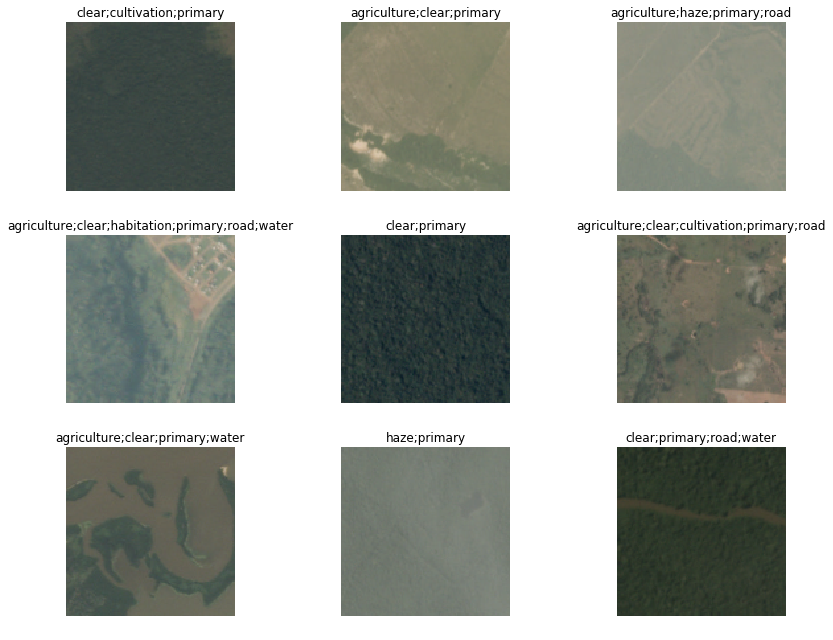

In [28]:
data.show_batch(rows=3, figsize=(12, 9))

En la variable 'arch' seleccionamos la arquitectura que tendrá nuestro modelo. En este caso una ResNet50.

In [29]:
arch = models.resnet50

En 'acc_02' determinamos la métrica y el límite de activación para medir la precisión. En 'f_score' especificamos la métrica que utiliza Kaggle para evaluar el rendimiento en esta competición. 'fbeta' está basada en la métrica [F1 score](https://en.wikipedia.org/wiki/F1_score).

En 'learn' creamos nuestro modelo, una 'cnn_learner' (Convolutional Neural Network), y le pasamos datos, arquitectura y métricas.

In [30]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Para conocer la tasa de aprendizaje de nuestro modelo (*learning rate*) utlilizamos la función "lr_find".

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Para visualizar el *learning rate* de nuestro modelo utilizamos la función "recorder.plot()".

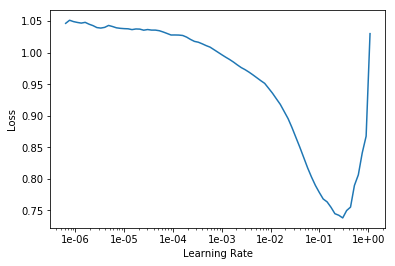

In [32]:
learn.recorder.plot()

Escogemos un 'lr' de 0.01.

In [33]:
lr = 0.01

Entrenamos nuestro modelo en 5 épocas. 

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138744,0.121657,0.935886,0.894228,02:50
1,0.111619,0.098675,0.950267,0.912096,02:48
2,0.103561,0.093621,0.955644,0.920374,02:48
3,0.096553,0.087483,0.956284,0.924663,02:48
4,0.092099,0.086276,0.956458,0.926525,02:48


Guardamos esta configuración en "stage-1-rn50".

In [35]:
learn.save('stage-1-rn50')

Una vez nuestro modelo termina la última época de entrenemiento, "cnn_learner" congela (*freeze*) los pesos (*weights*) obtenidos en cada capa para evitar perder, por accidente, el rendimeiento conseguido hasta el momento. Para poder reentrenar el modelo partiendo desde los últimos pesos, debemos descongelarlo (*unfreeze*).

In [36]:
learn.unfreeze()

Graficamos el nuevo *learning rate*.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


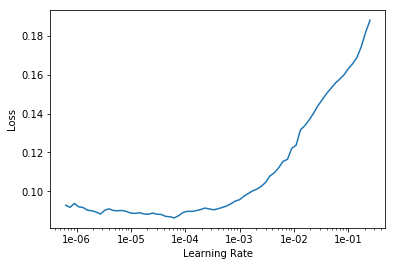

In [37]:
learn.lr_find()
learn.recorder.plot()

Entrenamos de nuevo el modelo en x épocas, esta vez con un *learning rate* de entre 1e-5 y la quinta parte de 'lr'.

In [38]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096084,0.091246,0.951815,0.920079,03:47
1,0.097301,0.091670,0.954256,0.921074,03:46
2,0.090548,0.086085,0.955622,0.926583,03:46
3,0.084187,0.082711,0.959503,0.929051,03:46
4,0.082130,0.082002,0.959052,0.929778,03:46


Guardamos esta configuración en "stage-2-rn50".

In [39]:
learn.save('stage-2-rn50')

Para intentar mejorar el rendimiento de nuestro modelo, vamos a redimensionar el tamaño de nuestras imágenes, pasamos de 128 x 128 a 256 x 256. Podemos consultar el tamaño de la primera imagen con la función 'shape'.

In [40]:
data = (src.transform(tfms, size=256)
      .databunch().normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

Congelamos el modelo antes de obtener el nuevo *learning rate*.

In [41]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


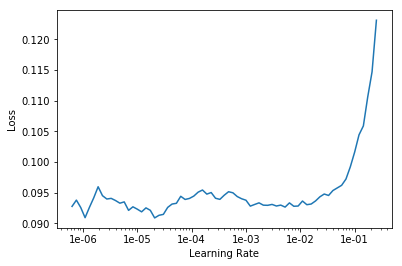

In [42]:
learn.lr_find()
learn.recorder.plot()

Asignamos en 'lr' un nuevo valor de *learning rate*.

In [43]:
lr = 1e-2/2

Entrenamos nuestro modelo con el nuevo conjunto de datos y el nuevo *learning rate*.

In [44]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086189,0.084618,0.956298,0.927435,09:55
1,0.085805,0.083518,0.958232,0.927629,09:52
2,0.083801,0.081939,0.959082,0.930394,09:52
3,0.082450,0.081240,0.959118,0.931040,09:51
4,0.079876,0.080787,0.959387,0.931392,09:51


Guardamos el resultado de esta nueva generación.

In [45]:
learn.save('stage-1-256-rn50')

Descongelamos y entrenamos de nuevo en 5 épocas con un nuevo *learning rate*.

In [46]:
learn.load('stage-1-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /storage/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /storage/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1

In [47]:
learn.unfreeze()

In [48]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085127,0.085362,0.957875,0.927070,12:50
1,0.085579,0.083894,0.957912,0.927372,12:46
2,0.082709,0.081766,0.957861,0.929459,12:47
3,0.078097,0.080563,0.958958,0.930794,12:47
4,0.073570,0.080566,0.960215,0.931295,12:47


Con la función 'recorder.plot_losses' podemos visualizar cómo se comporta nuestro modelo tanto en *training set* como en el *validation set*.

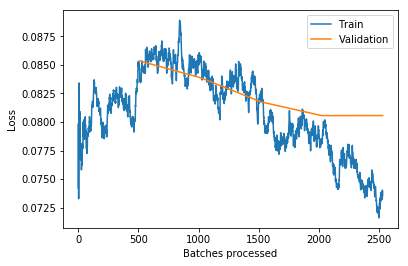

In [49]:
learn.recorder.plot_losses()

Guardamos y exportamos.

In [50]:
learn.save('stage-2-256-rn50')

In [51]:
learn.export()

# Conclusión

Con este ejercicio hemos aprendido un poco más sobre clasificación de imágenes y como una simple redimensión de las mismas puede afectar al rendimiento de un modelo.

Nuestra mejor 'fbeta' ha sido de 0.931392, lo que nos dejaría en la posición 26 de 938 en la clasificación de Kaggle.